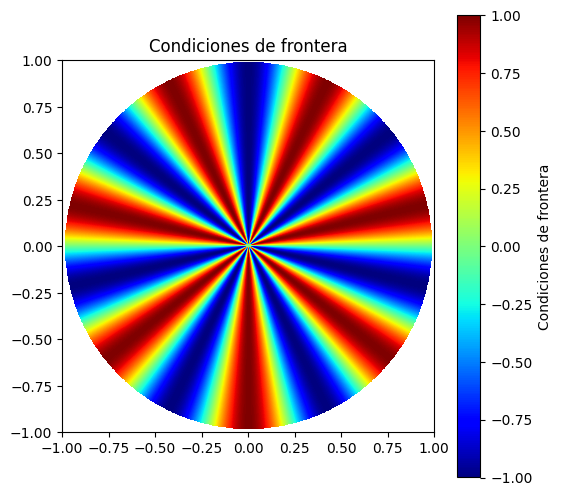

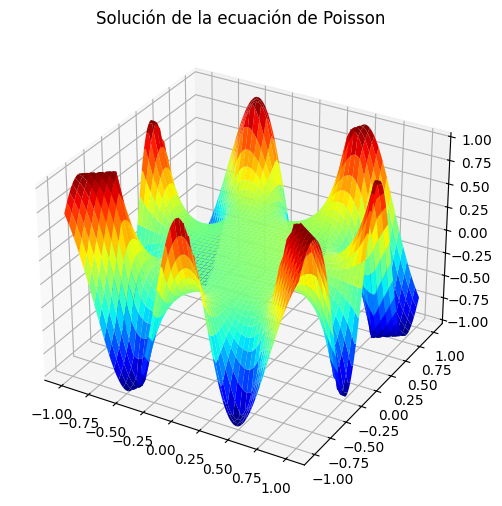

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit, prange

@njit(parallel=True)
def sor_iteration(phi, rho, X, Y, h, omega, max_iter, tol, phi_boundary):
    N = phi.shape[0]
    for _ in range(max_iter):
        phi_old = phi.copy()
        for i in prange(1, N-1):
            for j in prange(1, N-1):
                if X[i, j]**2 + Y[i, j]**2 < 1:
                    phi_new = 0.25 * (phi[i+1, j] + phi[i-1, j] + phi[i, j+1] + phi[i, j-1] - h**2 * rho[i, j])
                    phi[i, j] = (1 - omega) * phi[i, j] + omega * phi_new
        
        # Aplicar condición de frontera en el círculo unitario
        for i in prange(N):
            for j in prange(N):
                if X[i, j]**2 + Y[i, j]**2 >= 1:
                    phi[i, j] = phi_boundary[i, j]
        
        # Verificar convergencia con la traza de la diferencia
        if np.trace(np.abs(phi - phi_old)) < tol:
            break
    return phi

def poisson_solver(N=1000, tol=1e-4, max_iter=15000, omega=1.9):
    L = 1.01  # Dominio ligeramente más grande que el círculo unitario
    h = 2 * L / (N - 1)  # Tamaño del paso
    x = np.linspace(-L, L, N)
    y = np.linspace(-L, L, N)
    X, Y = np.meshgrid(x, y)
    
    # Inicializar la solución con valores aleatorios dentro del dominio
    phi = np.random.rand(N, N)  # Condición inicial aleatoria
    
    # Definir la densidad de carga
    rho = np.where(X**2 + Y**2 < 1, -X-Y, 0)
    
    # Aplicar condición de frontera en el círculo unitario
    theta = np.arctan2(Y, X)
    phi_boundary = np.sin(7 * theta)
    
    # Ejecutar iteraciones con Numba
    phi = sor_iteration(phi, rho, X, Y, h, omega, max_iter, tol, phi_boundary)
    
    return X, Y, phi, phi_boundary

# Resolver el problema
X, Y, phi, phi_boundary = poisson_solver()

# Graficar condiciones de frontera
fig, ax = plt.subplots(figsize=(6, 6))
circle = np.sqrt(X**2 + Y**2) < 1
cmap = plt.cm.jet
cmap.set_under('white')
im = ax.imshow(np.where(circle, phi_boundary, np.nan), extent=[-1, 1, -1, 1], origin='lower', cmap=cmap)
plt.colorbar(im, ax=ax, label='Condiciones de frontera')
ax.set_title('Condiciones de frontera')
plt.show()

# Graficar la solución 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, phi, cmap='jet', edgecolor='None')
plt.title('Solución de la ecuación de Poisson')
plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

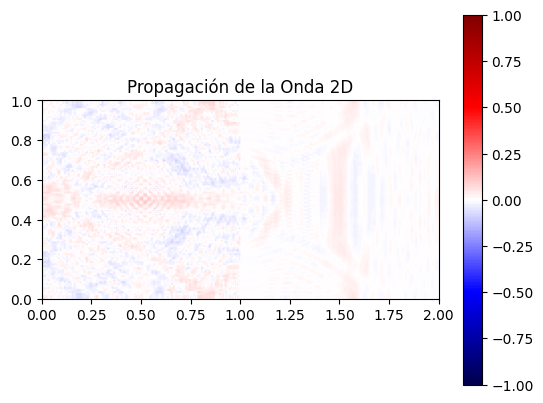

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parámetros de la simulación
Lx, Ly = 2.0, 1.0  # Tamaño del dominio
Nx, Ny = 200, 100  # Número de puntos en la malla
dx, dy = Lx / Nx, Ly / Ny  # Espaciado
dt = 0.002  # Paso de tiempo
Tmax = 2.0  # Tiempo total de simulación

# Velocidad variable en el medio
c0 = 1.0  # Velocidad base
c = np.ones((Ny, Nx)) * c0

# Definir una barrera con una abertura
barrera_x = Nx // 2
barrera_y1, barrera_y2 = Ny // 3, 2 * Ny // 3
c[:, barrera_x] = 0.0  # Poner la barrera
c[barrera_y1:barrera_y2, barrera_x] = c0  # Hacer una abertura

# Inicialización de la onda
u = np.zeros((Ny, Nx))
u_old = np.zeros((Ny, Nx))
u_new = np.zeros((Ny, Nx))

# Fuente inicial (onda gaussiana)
x0, y0 = Nx // 4, Ny // 2
sigma = 5
u[y0, x0] = 1.0

# Función para actualizar la onda en cada paso de tiempo
def update_wave():
    global u, u_old, u_new

    # Aplicar diferencias finitas para la ecuación de onda
    for i in range(1, Ny-1):
        for j in range(1, Nx-1):
            if c[i, j] > 0:  # No actualizar dentro de la barrera
                u_new[i, j] = (2 * u[i, j] - u_old[i, j] +
                               (c[i, j] * dt / dx)**2 * (u[i, j+1] - 2*u[i, j] + u[i, j-1]) +
                               (c[i, j] * dt / dy)**2 * (u[i+1, j] - 2*u[i, j] + u[i-1, j]))

    # Condiciones de frontera absorbentes (suavizan los bordes)
    u_new[0, :] = u_new[1, :]
    u_new[-1, :] = u_new[-2, :]
    u_new[:, 0] = u_new[:, 1]
    u_new[:, -1] = u_new[:, -2]

    # Intercambiar matrices
    u_old, u, u_new = u, u_new, u_old

# Configuración de la animación
fig, ax = plt.subplots()
cmap = ax.imshow(u, cmap='seismic', vmin=-1, vmax=1, extent=[0, Lx, 0, Ly])
plt.colorbar(cmap)
ax.set_title("Propagación de la Onda 2D")

def update(frame):
    update_wave()
    cmap.set_array(u)
    return [cmap]

# Crear animación
ani = animation.FuncAnimation(fig, update, frames=int(Tmax/dt), interval=20, blit=True)

# Guardar la animación en un video


# Mostrar la animación en pantalla
plt.show()


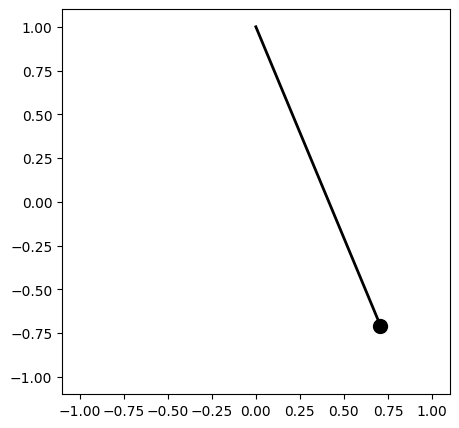

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Configuración inicial
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

# Crear elementos gráficos
pendulo, = ax.plot([], [], 'k-', lw=2)  # Cuerda
masa = ax.plot([], [], 'ko', markersize=10)[0]  # Masa

# Parámetros del péndulo
l = 1  # Longitud
g = 9.81  # Gravedad
theta0 = np.pi / 4  # Ángulo inicial
omega0 = 0  # Velocidad angular inicial
dt = 0.05  # Paso de tiempo
num_frames = 200

# Resolver ecuación de movimiento (simple)
theta = theta0 * np.cos(np.sqrt(g / l) * np.linspace(0, num_frames * dt, num_frames))

# Función de actualización
def update(i):
    x = l * np.sin(theta[i])
    y = -l * np.cos(theta[i])
    pendulo.set_data([0, x], [1, y])
    masa.set_data([x], [y])
    return pendulo, masa

# Crear animación
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=50, blit=False)

# Mostrar animación en Jupyter
HTML(ani.to_jshtml())


In [38]:
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] = r"C:\webm\bin"

print(animation.writers.list())


['pillow', 'html']
